# Description of the program
## Read training data and then train a ML model by a group of user data and then test the model accuracy
## Update the trained model by the profiles that are are projected by new random matrix

In [1]:
#Read all data
import csv
import pandas as pd
dataset=pd.read_csv('Dataset/OversampledSwipeData.csv', index_col=0)
dataset.head()

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,Label
0,0.052478,0.277631,0.451259,0.718039,0.462785,0.0,0.0,0.018702,0.167556,-0.021220,...,-0.000286,0.006156,0.000038,0.098039,0.175416,0.183196,0.083857,0.007032,0.183644,0
1,0.052112,0.329417,0.456423,0.707689,0.431129,0.0,0.0,0.018824,0.188321,-0.046427,...,-0.001681,0.006563,0.000043,0.172549,0.161923,0.174437,0.012390,0.000154,0.172166,0
2,0.044798,0.246703,0.482247,0.682013,0.413386,0.0,0.0,0.023549,0.219466,-0.084152,...,-0.003980,0.007612,0.000058,0.172549,0.165296,0.176905,0.015824,0.000250,0.179818,0
3,0.050101,0.292016,0.470626,0.711022,0.418269,0.0,0.0,0.019350,0.182533,-0.089321,...,0.000438,0.009006,0.000081,0.149020,0.165296,0.178174,0.036672,0.001343,0.183644,0
4,0.048638,0.282665,0.438347,0.712347,0.447676,0.0,0.0,0.023968,0.151995,-0.024688,...,-0.001410,0.007316,0.000054,0.125490,0.175416,0.184353,0.061493,0.003786,0.183644,0


In [2]:
#replace the user Level by class name and count the number of sample in each class
#dataset['Label'] = pd.factorize(dataset['Label'])[0]
dataset.groupby(['Label'])['Label'].count()

Label
0     300
1     300
2     300
3     300
4     300
     ... 
81    300
82    300
83    300
84    300
85    300
Name: Label, Length: 86, dtype: int64

In [3]:
#seperate the profile in two groups: (i) Training profile (0-43), and (ii) auxiliary profile (43-86)
totalUser= len(pd.unique(dataset['Label']))
trainingData = dataset[dataset['Label'] < 68]
auxilaryData = dataset[dataset['Label'] >= 68]
print("Total user in training dataset:", len(pd.unique(trainingData['Label'])))
print("Total user in auxiliary dataset:", len(pd.unique(auxilaryData['Label'])))

Total user in training dataset: 68
Total user in auxiliary dataset: 18


In [5]:
#total use in the system
totalUser= len(pd.unique(dataset['Label']))
#trainingData=dataset
print("Total user in the training dataset:", len(pd.unique(trainingData['Label'])))

Total user in the training dataset: 68


In [6]:
#Seperate the data for model training and attack
import tensorflow
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


Modeldataset, Updatedataset= train_test_split(trainingData,test_size=0.2, random_state=22)
#ytrain = to_categorical(Modeldataset)
#ytest = to_categorical()
print(Modeldataset.shape)
print(Updatedataset.shape)

(16320, 34)
(4080, 34)


In [7]:
#Random project the model dataset
import numpy as np
from sklearn.random_projection import SparseRandomProjection

column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30','Label']
column2=column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30']
ModeldatasetRP = pd.DataFrame(columns=column1)
for seed in range(0, 68):
    rng = np.random.RandomState(seed)
    X = Modeldataset[Modeldataset['Label'] == seed]

    if len(X) > 0:
        transformer = SparseRandomProjection(n_components=30, random_state=rng)
        Xdata = X.drop(columns=['Label'])
        XRP = pd.DataFrame(transformer.fit_transform(Xdata), columns=column2)
        XRP['Label'] = seed
        ModeldatasetRP = pd.concat([ModeldatasetRP, XRP], ignore_index=True)


print(Modeldataset.shape)
print(ModeldatasetRP.shape)


C:\Users\mdmor\AppData\Local\Temp\ipykernel_16732\1163549769.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ModeldatasetRP = pd.concat([ModeldatasetRP, XRP], ignore_index=True)


(16320, 34)
(16320, 31)


In [8]:
#Prepare the traning data for training and testing the model
import tensorflow
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X=ModeldatasetRP.drop(columns=['Label'])
y=ModeldatasetRP['Label']

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.1, random_state=22)
#Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.1, random_state=22)

ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
#ytest = to_categorical(ytest)

In [9]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)
#print(Xtest.shape)
#print(ytest.shape)

(14688, 30)
(14688, 68)
(1632, 30)
(1632, 68)


In [10]:
# import all necessary package for a neural network
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inlineimport keras
from keras.layers import Dense, Dropout, Input,Activation,Dropout, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
#from tqdm import tqdm
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
#import torch.nn.functional as F

In [13]:
#define optimizers for neural network
from keras.optimizers import SGD, RMSprop, Adam
def adam_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

def RMSprop_optimizer():
    return RMSprop(learning_rate=0.001, rho=0.9)

In [14]:
#neural network architecture for model training

def create_classifierRP(release=False,totalClass=68):
  classifier = Sequential()
  classifier.add(Dense(64, input_dim=30))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))
  classifier.add(Dropout(0.5))

  #classifier.add(Dense(256))
  #classifier.add(BatchNormalization())
  #classifier.add(Activation('relu'))

  classifier.add(Dense(128))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))
  classifier.add(Dropout(0.2))

  #classifier.add(Dense(256))
  #classifier.add(BatchNormalization())
  #classifier.add(Activation('relu'))

  #classifier.add(Dense(256))
  #classifier.add(BatchNormalization())
  #classifier.add(Activation('relu'))

  classifier.add(Dense(64))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))
  classifier.add(Dropout(0.2))

  #if release:
  classifier.add(Dense(totalClass, activation='softmax'))
  #else:
  #   classifier.add(Dense(Tuser))
  #np.log_softmax_v2(a, axis=axis)
  #classifier.add(F.softmax(a, dim=1))

  classifier.compile(loss='categorical_crossentropy', optimizer=RMSprop_optimizer(),metrics=['accuracy'])
  return classifier

Clasf=create_classifierRP()
Clasf.summary()

C:\Users\mdmor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 68)             │         4,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,004 (93.77 KB)

 Trainable params: 23,492 (91.77 KB)

 Non-trainable params: 512 (2.00 KB)

In [16]:
#Train the classifier seperately for black-box attack
import keras

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5,min_lr=0.0001)
callbacks_list = [learning_rate_reduction]

Classfier2= create_classifierRP(True,68)

#------Comment will start from here
lossc='categorical_crossentropy'
optimizerc=RMSprop(learning_rate=0.001, rho=0.9)
Classfier2.compile(loss=lossc, optimizer=optimizerc,metrics=['accuracy'])
#------Comments will end from here
historyc2 =  Classfier2.fit(Xtrain, ytrain, batch_size=64, epochs=20, validation_data=(Xval, yval),verbose=1)

Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2507 - loss: 3.3893 - val_accuracy: 0.9571 - val_loss: 1.7874
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7984 - loss: 1.2102 - val_accuracy: 1.0000 - val_loss: 0.1080
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8820 - loss: 0.5509 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9104 - loss: 0.3687 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9295 - loss: 0.2724 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9319 - loss: 0.2410 - val_accuracy: 1.0000 - val_loss: 5.4269e-04
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9417 - loss: 0.2085 - val_accuracy: 1.0000 - val_loss: 3.3115e-04
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9402 - loss: 0.1973 - val_accu

Text(0.5, 0, 'epochs')

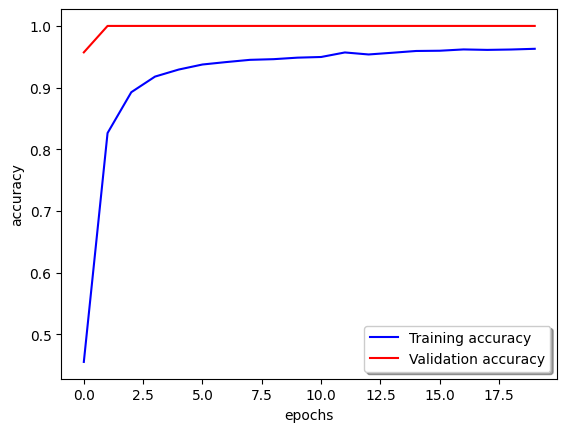

In [17]:
# Plot the classifier loss and accuracy curves for training and validation data
import matplotlib.pyplot as plt
plt.plot(historyc2.history['accuracy'], color='b', label="Training accuracy")
plt.plot(historyc2.history['val_accuracy'], color='r',label="Validation accuracy")
legend = plt.legend(loc='best', shadow=True)
plt.ylabel('accuracy')
plt.xlabel('epochs')

In [18]:
#read the test data and seperate test data
import csv
import pandas as pd
testdataset=pd.read_csv('Dataset/SwipeDatatest.csv',index_col=0)
testdataset = testdataset[testdataset['Label'] < 68]
#testdataset.head()

In [19]:
#random project the test data by using same random matrix
import numpy as np
from sklearn.random_projection import SparseRandomProjection
column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30','Label']
column2=column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30']
testdatasetRP = pd.DataFrame(columns=column1)

for seed in range(0,68):
    rng = np.random.RandomState(seed)
    X = testdataset[testdataset['Label']==seed]
    transformer = SparseRandomProjection(n_components=30, random_state=rng)
    Xdata=X.drop(columns=['Label'])
    XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
    XRP['Label']=seed
    testdatasetRP = pd.concat([testdatasetRP, XRP], ignore_index=True)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(testdataset.shape)
print(testdatasetRP.shape)

C:\Users\mdmor\AppData\Local\Temp\ipykernel_16732\416251678.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  testdatasetRP = pd.concat([testdatasetRP, XRP], ignore_index=True)


(1639, 34)
(1639, 31)


In [20]:
Xtest=testdatasetRP.drop(columns=['Label'])
ytest=testdatasetRP['Label']
ytest = to_categorical(ytest)

In [21]:
#Performance of the classifier
Classfier2.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
loss, accuracy = Classfier2.evaluate(Xtest, ytest)
#print('Test score:', score)
print('Loss:', loss)
print('Accuracy:', accuracy)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9987 - loss: 0.0036     
Loss: 0.0016466304659843445
Accuracy: 0.9993898868560791


In [22]:
#save the Model
from keras.models import load_model
keras.backend.clear_session()
filename = 'Dataset/UserModel1.h5'
Classfier2.save(filename)
#UserModel = load_model(filename)


# Model Update

In [23]:
#load  the Model
from keras.models import load_model
keras.backend.clear_session()
filename = 'Dataset/UserModel1.h5'
#Classfier2.save(filename)
UserModel = load_model(filename)

In [24]:
#Random project the Update dataset
import numpy as np
from sklearn.random_projection import SparseRandomProjection

column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30','Label']
column2=column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30']
UpdatedatasetRP = pd.DataFrame(columns=column1)
for seed in range(0,68):
    rng = np.random.RandomState(seed+1)
    X = Updatedataset[Updatedataset['Label']==seed]
    if len(X) > 0:
      transformer = SparseRandomProjection(n_components=30, random_state=rng)
      Xdata=X.drop(columns=['Label'])
      XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
      XRP['Label']=seed
      UpdatedatasetRP = pd.concat([UpdatedatasetRP, XRP], ignore_index=True)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(Updatedataset.shape)
print(UpdatedatasetRP.shape)

C:\Users\mdmor\AppData\Local\Temp\ipykernel_16732\2382357389.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  UpdatedatasetRP = pd.concat([UpdatedatasetRP, XRP], ignore_index=True)


(4080, 34)
(4080, 31)


In [25]:
#Performance of the classifier (no need)
XUpdatedataset=UpdatedatasetRP.drop(columns=['Label'])
yUpdatedataset=UpdatedatasetRP['Label']
yUpdatedataset=to_categorical(yUpdatedataset)

#Classfier2.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
loss, accuracy = UserModel.evaluate(XUpdatedataset, yUpdatedataset)
#print('Test score:', score)
print('Loss:', loss)
print('Accuracy:', accuracy)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 18.9654
Loss: 19.53427505493164
Accuracy: 0.0


In [26]:
X=UpdatedatasetRP.drop(columns=['Label'])
y=UpdatedatasetRP['Label']

XUpdate, XUpdateval, yUpdate, yUpdateval = train_test_split(X, y, test_size=0.1, random_state=22)
#XUpdate, XUpdateval, yUpdate, yUpdateval = train_test_split(XUpdate, yUpdate, test_size=0.1, random_state=22)

yUpdate = to_categorical(yUpdate)
yUpdateval = to_categorical(yUpdateval)
#yUpdatetest = to_categorical(yUpdatetest)

In [27]:
print(XUpdate.shape)
print(yUpdate.shape)
print(XUpdateval.shape)
print(yUpdateval.shape)
#print(XUpdatetest.shape)
#print(yUpdatetest.shape)

(3672, 30)
(3672, 68)
(408, 30)
(408, 68)


In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5,min_lr=0.0001)
callbacks_list = [learning_rate_reduction]

#------Comment will start from here
lossc='categorical_crossentropy'
optimizerc=RMSprop(learning_rate=0.001, rho=0.9)
UserModel.compile(loss=lossc, optimizer=optimizerc,metrics=['accuracy'])
#------Comments will end from here
historyc3=UserModel.fit(XUpdate, yUpdate, batch_size=64, epochs=20, validation_data=(XUpdateval, yUpdateval))

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0222 - loss: 15.2048 - val_accuracy: 0.0662 - val_loss: 7.3884
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1629 - loss: 5.5970 - val_accuracy: 0.5441 - val_loss: 1.7273
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3677 - loss: 2.7186 - val_accuracy: 0.8309 - val_loss: 0.6690
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5294 - loss: 1.7740 - val_accuracy: 0.9118 - val_loss: 0.4284
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6251 - loss: 1.2969 - val_accuracy: 0.9657 - val_loss: 0.2846
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6993 - loss: 1.0419 - val_accuracy: 0.9730 - val_loss: 0.1909
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7493 - loss: 0.8445 - val_accuracy: 0.9828 - val_loss: 0.1222
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - loss: 0.7255 - val_accuracy: 0.9975 - val_loss

Text(0.5, 0, 'epochs')

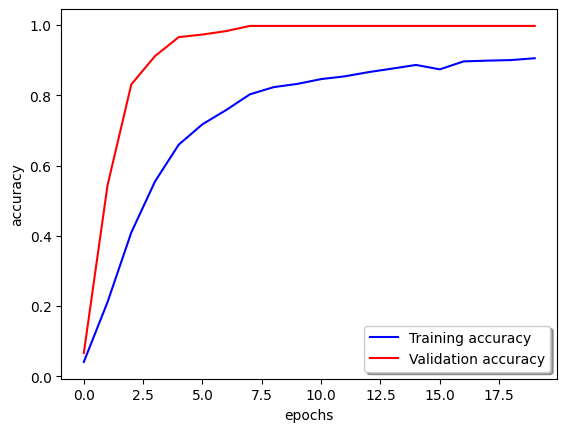

In [29]:
# Plot the classifier loss and accuracy curves for training and validation data
import matplotlib.pyplot as plt
plt.plot(historyc3.history['accuracy'], color='b', label="Training accuracy")
plt.plot(historyc3.history['val_accuracy'], color='r',label="Validation accuracy")
legend = plt.legend(loc='best', shadow=True)
plt.ylabel('accuracy')
plt.xlabel('epochs')

# Updated model test by same random mareix

In [30]:
#read the test data and seperate test data
import csv
import pandas as pd
testdataset=pd.read_csv('Dataset/SwipeDatatest.csv',index_col=0)
testdataset = testdataset[testdataset['Label'] < 68]
#testdataset.head()

In [31]:
#random project the test data by using same random matrix
from sklearn.random_projection import SparseRandomProjection

import numpy as np
column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30','Label']
column2=column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30']
testdatasetRP = pd.DataFrame(columns=column1)

for seed in range(0,68):
    rng = np.random.RandomState(seed+1)
    X = testdataset[testdataset['Label']==seed]
    transformer = SparseRandomProjection(n_components=30, random_state=rng)
    Xdata=X.drop(columns=['Label'])
    XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
    XRP['Label']=seed
    testdatasetRP = pd.concat([testdatasetRP, XRP], ignore_index=True)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(testdataset.shape)
print(testdatasetRP.shape)

C:\Users\mdmor\AppData\Local\Temp\ipykernel_16732\2967892579.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  testdatasetRP = pd.concat([testdatasetRP, XRP], ignore_index=True)


(1639, 34)
(1639, 31)


In [32]:
Xtest=testdatasetRP.drop(columns=['Label'])
ytest=testdatasetRP['Label']
ytest = to_categorical(ytest)

In [33]:
#Performance of the classifier
#UserModel.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
loss, accuracy = UserModel.evaluate(Xtest, ytest)
#print('Test score:', score)
print('Loss:', loss)
print('Accuracy:', accuracy)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0072
Loss: 0.003970648627728224
Accuracy: 0.9993898868560791


# Updated model test by different random mareix

In [34]:
#read the test data and seperate test data
import csv
import pandas as pd
testdataset=pd.read_csv('Dataset/SwipeDatatest.csv',index_col=0)
testdataset = testdataset[testdataset['Label'] < 68]
#testdataset.head()

In [35]:
#random project the test data by using same random matrix
from sklearn.random_projection import SparseRandomProjection

import numpy as np
column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30','Label']
column2=column1=['RPF1', 'RPF2', 'RPF3', 'RPF4', 'RPF5', 'RPF6', 'RPF7', 'RPF8', 'RPF9', 'RPF10', 'RPF11', 'RPF12', 'RPF13', 'RPF14', 'RPF15', 'RPF16', 'RPF17', 'RPF18',
         'RPF19', 'RPF20', 'RPF21', 'RPF22', 'RPF23', 'RPF24', 'RPF25', 'RPF26', 'RPF27', 'RPF28', 'RPF29', 'RPF30']
testdatasetRP = pd.DataFrame(columns=column1)

for seed in range(0,68):
    rng = np.random.RandomState(seed)
    X = testdataset[testdataset['Label']==seed]
    transformer = SparseRandomProjection(n_components=30, random_state=rng)
    Xdata=X.drop(columns=['Label'])
    XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
    XRP['Label']=seed
    testdatasetRP = pd.concat([testdatasetRP, XRP], ignore_index=True)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(testdataset.shape)
print(testdatasetRP.shape)

C:\Users\mdmor\AppData\Local\Temp\ipykernel_16732\1214112297.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  testdatasetRP = pd.concat([testdatasetRP, XRP], ignore_index=True)


(1639, 34)
(1639, 31)


In [36]:
Xtest=testdatasetRP.drop(columns=['Label'])
ytest=testdatasetRP['Label']
ytest = to_categorical(ytest)

In [37]:
#Performance of the classifier
#UserModel.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
loss, accuracy = UserModel.evaluate(Xtest, ytest)
#print('Test score:', score)
print('Loss:', loss)
print('Accuracy:', accuracy)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0095 - loss: 9.8874    
Loss: 9.740232467651367
Accuracy: 0.023794997483491898
